In [1]:
import argparse
import os
import numpy as np
import math
import sys


import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from Tools import NNE

import matplotlib.cm as cm

from tqdm import trange

In [2]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
device

device(type='cuda', index=0)

In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim,samples_dim,bias):
        super(Generator, self).__init__()
        self.bias=bias.clone().requires_grad_(False)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(1., inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, samples_dim)
        )

    def forward(self, z):
        img = self.model(z)+self.bias
        return img


In [4]:

class Discriminator(nn.Module):
    def __init__(self, samples_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
             nn.Linear(samples_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )

    def forward(self, X):
        #validity =torch.sin(self.model(X))#self.model(X)
        validity =self.model(X)
        return validity

In [5]:
relu=torch.nn.ReLU(inplace=False)
def compute_norm_penalty(D, real, fake):
    all_data=torch.cat([real,fake],dim=0) 
    d_values = D(all_data)
    
    norm_penalty = d_values.norm()**2#(relu(d_values.abs()-1.)**2)    
    return norm_penalty.mean()


def compute_gradient_penalty(discriminator, real, fake):
    assert real.shape==fake.shape
    batch_size=real.shape[0]
    eta = torch.FloatTensor(batch_size,1).uniform_(0,1)
    eta = eta.expand(batch_size, real.size(1)).to(device)
  
    interpolated = (eta * real + ((1 - eta) * fake)).requires_grad_(True)

    # calculate probability of interpolated examples
    prob_interpolated = discriminator(interpolated)

    # calculate gradients of probabilities with respect to examples
    gradients = autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(
                               prob_interpolated.size(), device=device),
                           create_graph=True, retain_graph=True)[0]
    grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return grad_penalty

# Data #

In [6]:
from Experiments.foong import Setup
layerwidth=50
nblayers=1
input_dim=1
setup=Setup(device,layerwidth=layerwidth,nblayers=nblayers)


In [7]:
X_train, y_train=setup.train_data()
param_count=setup.param_count
model=setup._model
prediction=setup.prediction
projection=setup.projection
loglikelihood=setup.loglikelihood
logposterior=setup.logposterior
sqloss=setup.sqloss

X_train.shape, y_train.shape

(torch.Size([120, 1]), torch.Size([120, 1]))

In [8]:
from Inference.PointEstimate import AdamGradientDescent
def _MAP(nbiter, std_init,logposterior, dim, device=device):
        optimizer = AdamGradientDescent(logposterior, nbiter, .01, .00000001, 50, .5, device, True)

        theta0 = torch.empty((1, dim), device=device).normal_(0., std=std_init)
        best_theta, best_score, score = optimizer.run(theta0)

        return best_theta.detach().clone()

theta=_MAP(10000,1., logposterior, param_count)

Epoch [1/10000], Loss: 32632.68359375, Learning Rate: 0.01
Epoch [2/10000], Loss: 20890.646484375, Learning Rate: 0.01
Epoch [3/10000], Loss: 12265.5703125, Learning Rate: 0.01
Epoch [4/10000], Loss: 6617.0341796875, Learning Rate: 0.01
Epoch [5/10000], Loss: 3574.40625, Learning Rate: 0.01
Epoch [6/10000], Loss: 2532.004638671875, Learning Rate: 0.01
Epoch [7/10000], Loss: 2736.607666015625, Learning Rate: 0.01
Epoch [8/10000], Loss: 3476.0791015625, Learning Rate: 0.01
Epoch [9/10000], Loss: 4243.95361328125, Learning Rate: 0.01
Epoch [10/10000], Loss: 4780.21875, Learning Rate: 0.01
Epoch [11/10000], Loss: 5014.95703125, Learning Rate: 0.01
Epoch [12/10000], Loss: 4985.404296875, Learning Rate: 0.01
Epoch [13/10000], Loss: 4766.6005859375, Learning Rate: 0.01
Epoch [14/10000], Loss: 4428.01806640625, Learning Rate: 0.01
Epoch [15/10000], Loss: 4016.882080078125, Learning Rate: 0.01
Epoch [16/10000], Loss: 3561.01708984375, Learning Rate: 0.01
Epoch [17/10000], Loss: 3080.10473632812

Epoch [168/10000], Loss: 235.24093627929688, Learning Rate: 0.01
Epoch [169/10000], Loss: 233.70330810546875, Learning Rate: 0.01
Epoch [170/10000], Loss: 232.1894073486328, Learning Rate: 0.01
Epoch [171/10000], Loss: 230.69944763183594, Learning Rate: 0.01
Epoch [172/10000], Loss: 229.23289489746094, Learning Rate: 0.01
Epoch [173/10000], Loss: 227.78958129882812, Learning Rate: 0.01
Epoch [174/10000], Loss: 226.36920166015625, Learning Rate: 0.01
Epoch [175/10000], Loss: 224.9713592529297, Learning Rate: 0.01
Epoch [176/10000], Loss: 223.59591674804688, Learning Rate: 0.01
Epoch [177/10000], Loss: 222.24252319335938, Learning Rate: 0.01
Epoch [178/10000], Loss: 220.91065979003906, Learning Rate: 0.01
Epoch [179/10000], Loss: 219.60040283203125, Learning Rate: 0.01
Epoch [180/10000], Loss: 218.31114196777344, Learning Rate: 0.01
Epoch [181/10000], Loss: 217.0425262451172, Learning Rate: 0.01
Epoch [182/10000], Loss: 215.79466247558594, Learning Rate: 0.01
Epoch [183/10000], Loss: 214

Epoch [332/10000], Loss: 151.75253295898438, Learning Rate: 0.01
Epoch [333/10000], Loss: 151.6735076904297, Learning Rate: 0.01
Epoch [334/10000], Loss: 151.59547424316406, Learning Rate: 0.01
Epoch [335/10000], Loss: 151.5186767578125, Learning Rate: 0.01
Epoch [336/10000], Loss: 151.44296264648438, Learning Rate: 0.01
Epoch [337/10000], Loss: 151.3682861328125, Learning Rate: 0.01
Epoch [338/10000], Loss: 151.29440307617188, Learning Rate: 0.01
Epoch [339/10000], Loss: 151.22171020507812, Learning Rate: 0.01
Epoch [340/10000], Loss: 151.1499786376953, Learning Rate: 0.01
Epoch [341/10000], Loss: 151.0791473388672, Learning Rate: 0.01
Epoch [342/10000], Loss: 151.0091552734375, Learning Rate: 0.01
Epoch [343/10000], Loss: 150.9400177001953, Learning Rate: 0.01
Epoch [344/10000], Loss: 150.87179565429688, Learning Rate: 0.01
Epoch [345/10000], Loss: 150.80442810058594, Learning Rate: 0.01
Epoch [346/10000], Loss: 150.73788452148438, Learning Rate: 0.01
Epoch [347/10000], Loss: 150.672

Epoch [496/10000], Loss: 143.94398498535156, Learning Rate: 0.01
Epoch [497/10000], Loss: 143.90365600585938, Learning Rate: 0.01
Epoch [498/10000], Loss: 143.8634796142578, Learning Rate: 0.01
Epoch [499/10000], Loss: 143.82339477539062, Learning Rate: 0.01
Epoch [500/10000], Loss: 143.78309631347656, Learning Rate: 0.01
Epoch [501/10000], Loss: 143.74298095703125, Learning Rate: 0.01
Epoch [502/10000], Loss: 143.702880859375, Learning Rate: 0.01
Epoch [503/10000], Loss: 143.66270446777344, Learning Rate: 0.01
Epoch [504/10000], Loss: 143.6224365234375, Learning Rate: 0.01
Epoch [505/10000], Loss: 143.5823974609375, Learning Rate: 0.01
Epoch [506/10000], Loss: 143.54205322265625, Learning Rate: 0.01
Epoch [507/10000], Loss: 143.50204467773438, Learning Rate: 0.01
Epoch [508/10000], Loss: 143.46182250976562, Learning Rate: 0.01
Epoch [509/10000], Loss: 143.421630859375, Learning Rate: 0.01
Epoch [510/10000], Loss: 143.38137817382812, Learning Rate: 0.01
Epoch [511/10000], Loss: 143.341

Epoch [660/10000], Loss: 137.36019897460938, Learning Rate: 0.01
Epoch [661/10000], Loss: 137.32034301757812, Learning Rate: 0.01
Epoch [662/10000], Loss: 137.2803497314453, Learning Rate: 0.01
Epoch [663/10000], Loss: 137.24038696289062, Learning Rate: 0.01
Epoch [664/10000], Loss: 137.2005615234375, Learning Rate: 0.01
Epoch [665/10000], Loss: 137.16064453125, Learning Rate: 0.01
Epoch [666/10000], Loss: 137.12074279785156, Learning Rate: 0.01
Epoch [667/10000], Loss: 137.080810546875, Learning Rate: 0.01
Epoch [668/10000], Loss: 137.04090881347656, Learning Rate: 0.01
Epoch [669/10000], Loss: 137.00106811523438, Learning Rate: 0.01
Epoch [670/10000], Loss: 136.9611358642578, Learning Rate: 0.01
Epoch [671/10000], Loss: 136.92124938964844, Learning Rate: 0.01
Epoch [672/10000], Loss: 136.8814697265625, Learning Rate: 0.01
Epoch [673/10000], Loss: 136.84156799316406, Learning Rate: 0.01
Epoch [674/10000], Loss: 136.80172729492188, Learning Rate: 0.01
Epoch [675/10000], Loss: 136.76190

Epoch [824/10000], Loss: 130.98074340820312, Learning Rate: 0.01
Epoch [825/10000], Loss: 130.94354248046875, Learning Rate: 0.01
Epoch [826/10000], Loss: 130.90623474121094, Learning Rate: 0.01
Epoch [827/10000], Loss: 130.86898803710938, Learning Rate: 0.01
Epoch [828/10000], Loss: 130.8318328857422, Learning Rate: 0.01
Epoch [829/10000], Loss: 130.79457092285156, Learning Rate: 0.01
Epoch [830/10000], Loss: 130.75741577148438, Learning Rate: 0.01
Epoch [831/10000], Loss: 130.72039794921875, Learning Rate: 0.01
Epoch [832/10000], Loss: 130.68328857421875, Learning Rate: 0.01
Epoch [833/10000], Loss: 130.64617919921875, Learning Rate: 0.01
Epoch [834/10000], Loss: 130.60914611816406, Learning Rate: 0.01
Epoch [835/10000], Loss: 130.57212829589844, Learning Rate: 0.01
Epoch [836/10000], Loss: 130.53500366210938, Learning Rate: 0.01
Epoch [837/10000], Loss: 130.49819946289062, Learning Rate: 0.01
Epoch [838/10000], Loss: 130.461181640625, Learning Rate: 0.01
Epoch [839/10000], Loss: 130

Epoch [987/10000], Loss: 125.30036926269531, Learning Rate: 0.01
Epoch [988/10000], Loss: 125.26821899414062, Learning Rate: 0.01
Epoch [989/10000], Loss: 125.23605346679688, Learning Rate: 0.01
Epoch [990/10000], Loss: 125.20384979248047, Learning Rate: 0.01
Epoch [991/10000], Loss: 125.17173767089844, Learning Rate: 0.01
Epoch [992/10000], Loss: 125.13961791992188, Learning Rate: 0.01
Epoch [993/10000], Loss: 125.10749816894531, Learning Rate: 0.01
Epoch [994/10000], Loss: 125.07545471191406, Learning Rate: 0.01
Epoch [995/10000], Loss: 125.04350280761719, Learning Rate: 0.01
Epoch [996/10000], Loss: 125.01145935058594, Learning Rate: 0.01
Epoch [997/10000], Loss: 124.9796371459961, Learning Rate: 0.01
Epoch [998/10000], Loss: 124.9476318359375, Learning Rate: 0.01
Epoch [999/10000], Loss: 124.9157485961914, Learning Rate: 0.01
Epoch [1000/10000], Loss: 124.88402557373047, Learning Rate: 0.01
Epoch [1001/10000], Loss: 124.85208129882812, Learning Rate: 0.01
Epoch [1002/10000], Loss: 

Epoch [1151/10000], Loss: 120.3994369506836, Learning Rate: 0.01
Epoch [1152/10000], Loss: 120.37162780761719, Learning Rate: 0.01
Epoch [1153/10000], Loss: 120.34382629394531, Learning Rate: 0.01
Epoch [1154/10000], Loss: 120.31621551513672, Learning Rate: 0.01
Epoch [1155/10000], Loss: 120.28851318359375, Learning Rate: 0.01
Epoch [1156/10000], Loss: 120.26083374023438, Learning Rate: 0.01
Epoch [1157/10000], Loss: 120.23321533203125, Learning Rate: 0.01
Epoch [1158/10000], Loss: 120.20561218261719, Learning Rate: 0.01
Epoch [1159/10000], Loss: 120.17794036865234, Learning Rate: 0.01
Epoch [1160/10000], Loss: 120.15036010742188, Learning Rate: 0.01
Epoch [1161/10000], Loss: 120.12274169921875, Learning Rate: 0.01
Epoch [1162/10000], Loss: 120.09519958496094, Learning Rate: 0.01
Epoch [1163/10000], Loss: 120.0676498413086, Learning Rate: 0.01
Epoch [1164/10000], Loss: 120.04017639160156, Learning Rate: 0.01
Epoch [1165/10000], Loss: 120.01275634765625, Learning Rate: 0.01
Epoch [1166/

KeyboardInterrupt: 

In [9]:
bias=torch.zeros(param_count).to(device)

#bias=theta.detach().clone().to(device) #

In [45]:
lat_dim=100
samples_dim=param_count
n_samples=X_train.shape[0]
k_MC=10


# Initialize generator and discriminator
generator = Generator(lat_dim,param_count,bias)
discriminator = Discriminator(k_MC+n_samples)


if cuda:
    generator.cuda()
    discriminator.cuda()
generator, discriminator

(Generator(
   (model): Sequential(
     (0): Linear(in_features=100, out_features=128, bias=True)
     (1): LeakyReLU(negative_slope=1.0, inplace=True)
     (2): Linear(in_features=128, out_features=256, bias=True)
     (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
     (4): LeakyReLU(negative_slope=1.0, inplace=True)
     (5): Linear(in_features=256, out_features=512, bias=True)
     (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
     (7): LeakyReLU(negative_slope=1.0, inplace=True)
     (8): Linear(in_features=512, out_features=1024, bias=True)
     (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
     (10): LeakyReLU(negative_slope=1.0, inplace=True)
     (11): Linear(in_features=1024, out_features=151, bias=True)
   )
 ),
 Discriminator(
   (model): Sequential(
     (0): Linear(in_features=130, out_features=512, bias=True)
     (1): LeakyReLU(negative_slope=0.2, inplace=T

<IPython.core.display.Javascript object>


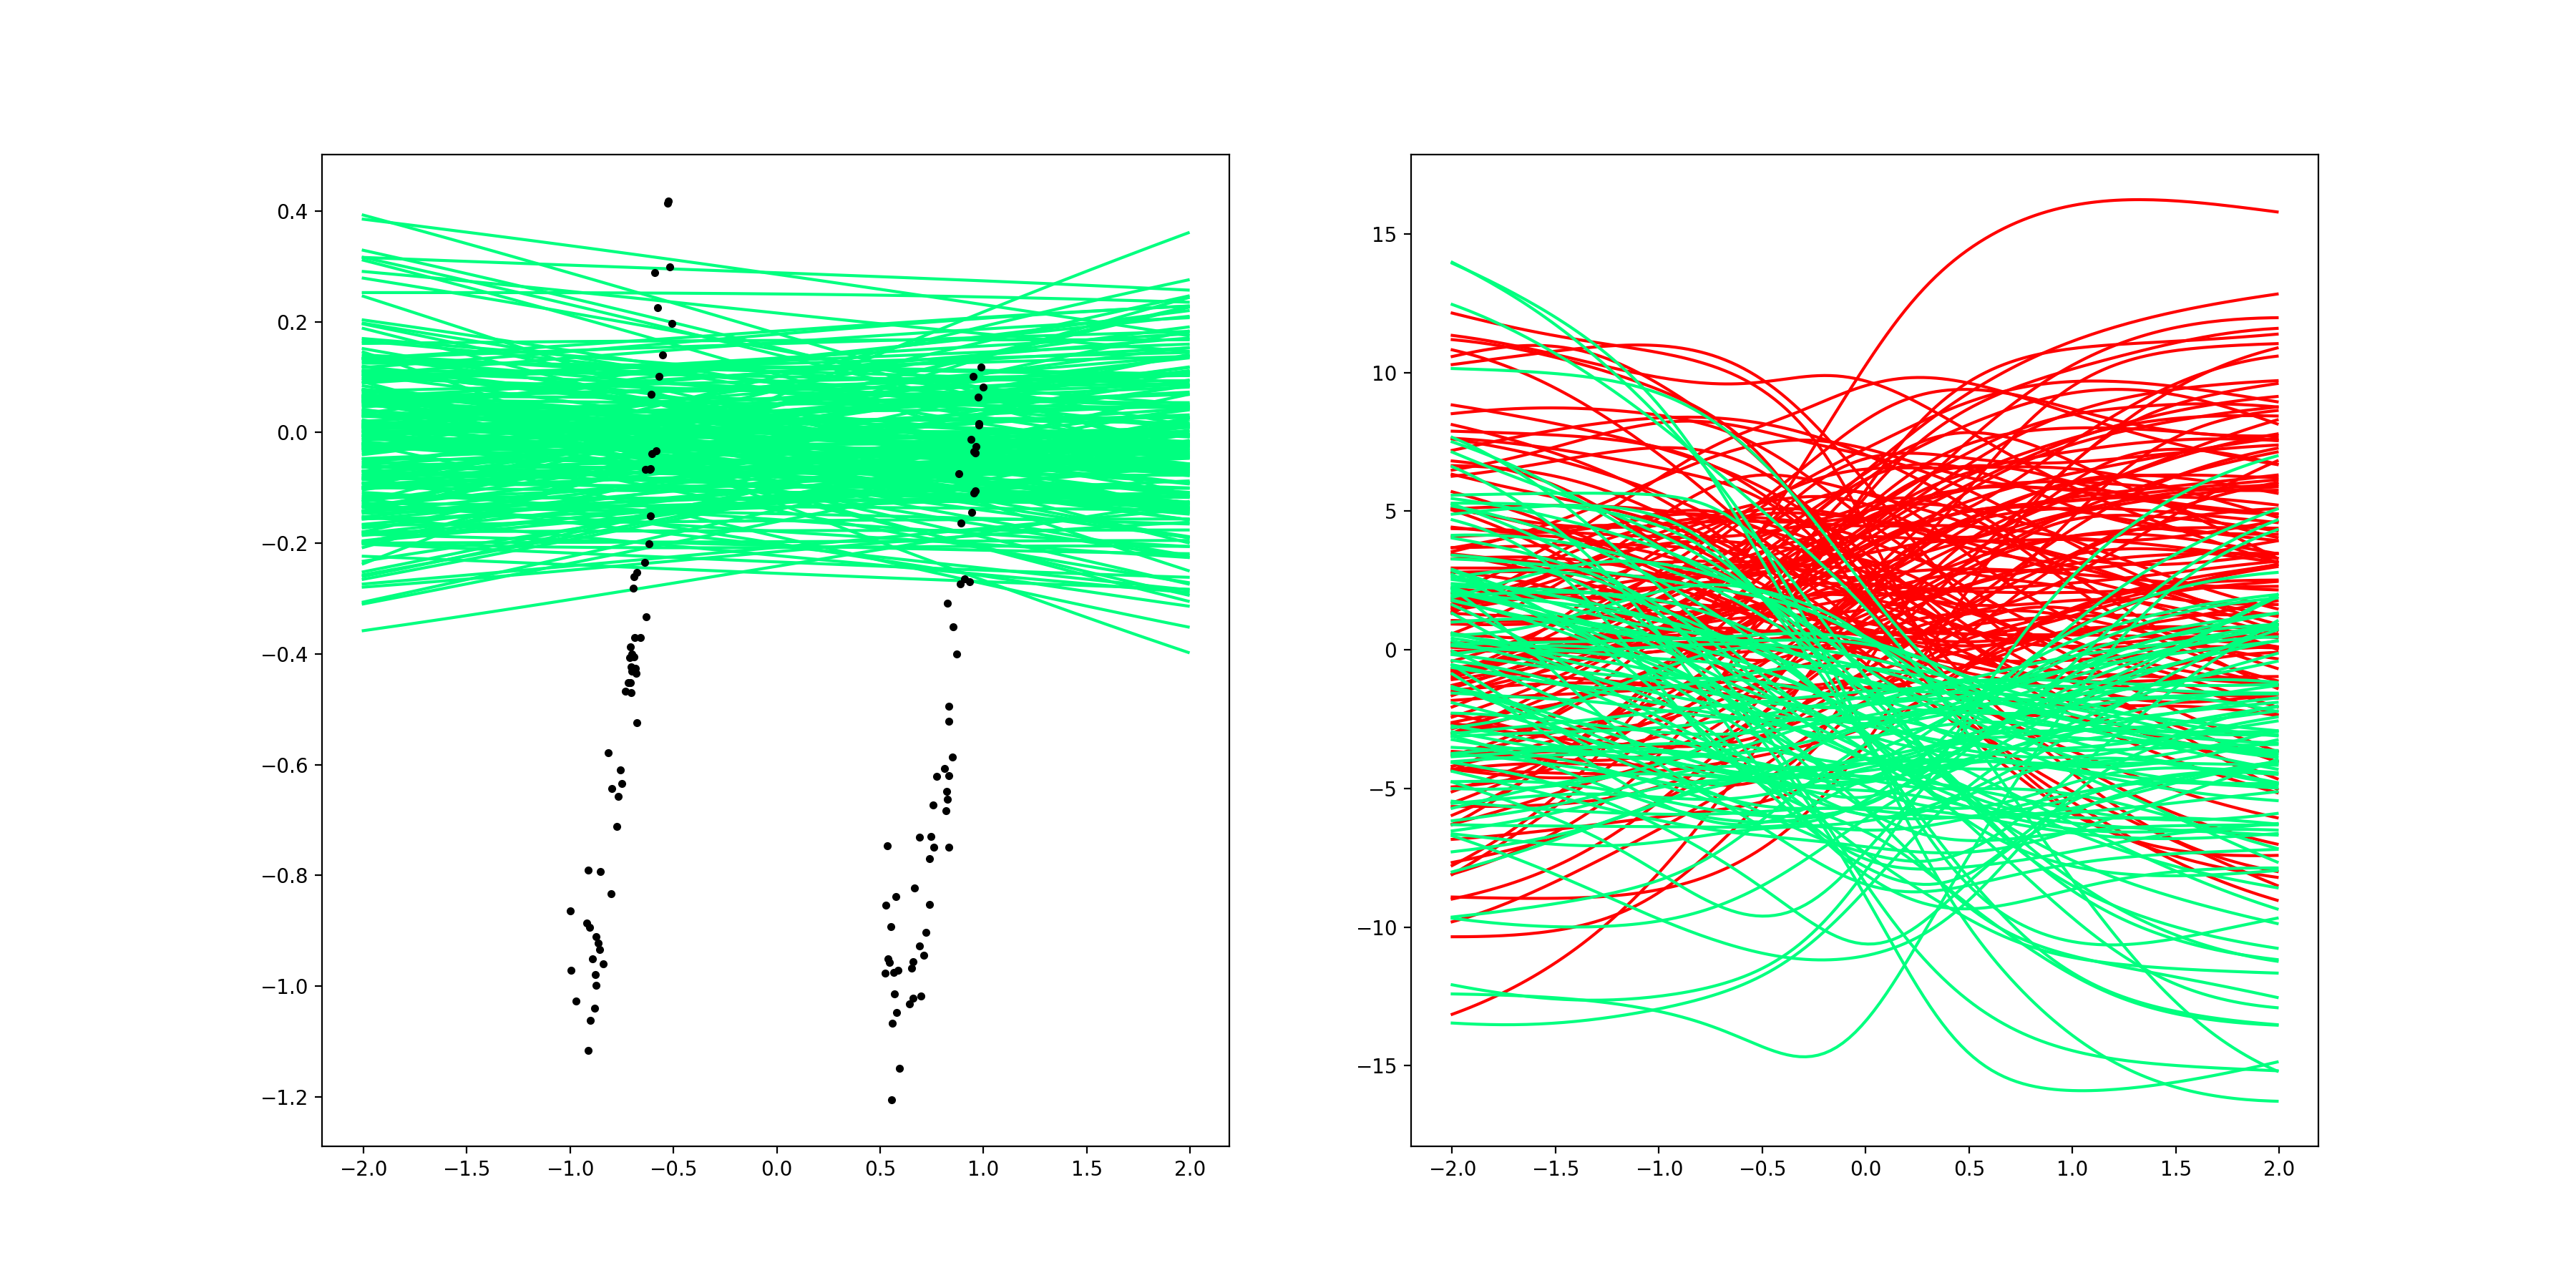

In [42]:
class LivePlotNotebook(object):
    """
    Live plot using %matplotlib notebook in jupyter notebook
    
    Usage:
    ```
    import time
    liveplot = LivePlotNotebook()
    x=np.random.random((10,))
    for i in range(10):
        time.sleep(1)
        liveplot.update(
            x=x+np.random.random(x.shape)/10,
            actions=np.random.randint(0, 3, size=(10,))
        )
    ```
    
    url:
    """

    def __init__(self, G,D, n=200):
        %matplotlib notebook
        fig,(ax0,ax1) = plt.subplots(1,2, figsize=(18,9))
        fig.tight_layout
        self.n=n
        x_lin=torch.arange(-2.,2.,0.03).to(device)
        self.x_lin=x_lin
        
        
        z = Tensor(np.random.normal(0, 1, (n, lat_dim)))
        self.z=z
        
        prior=Tensor(np.random.normal(0, 1, (n, param_count)))
        self.prior=prior
        
        ax0.scatter(X_train.cpu(), y_train.cpu(), marker='.',color='black',zorder=4)
        
        theta_fake=G(z)
        for i in range(n):
            y_pred_fake = prediction(x_lin, theta_fake[i,:].unsqueeze(0))
            ax0.plot(x_lin.detach().cpu().numpy(), y_pred_fake.squeeze(0).detach().cpu().numpy(), color='springgreen')
            
            y_pred = prediction(x_lin, prior[i,:].unsqueeze(0))
            func= projection(self.prior[i,:].unsqueeze(0),k_MC)
            d=discriminator(func).detach().squeeze().cpu()
            if d>0.:
                ax1.plot(x_lin.detach().cpu().numpy(), y_pred.squeeze(0).detach().cpu().numpy(), color='springgreen', zorder=1)
            if d<0.:
                ax1.plot(x_lin.detach().cpu().numpy(), y_pred.squeeze(0).detach().cpu().numpy(), color='red', zorder=0)

        
        self.ax0 = ax0
        self.ax1 = ax1
        self.fig = fig

    def update(self, G,D):             
        # update price
        self.ax0.clear()
        self.ax1.clear()
        theta_fake=G(self.z)
        self.ax0.scatter(X_train.cpu(), y_train.cpu(), marker='.',color='black',zorder=4)
        
        for i in range(self.n):
            y_pred_fake = prediction(self.x_lin, theta_fake[i,:].unsqueeze(0))
            self.ax0.plot(self.x_lin.detach().cpu().numpy(), y_pred_fake.squeeze(0).detach().cpu().numpy(), color='springgreen')
            
            y_pred = prediction(self.x_lin, self.prior[i,:].unsqueeze(0))
            func= projection(self.prior[i,:].unsqueeze(0),k_MC)
            d=discriminator(func).detach().squeeze().cpu()
            if d>0.:
                self.ax1.plot(self.x_lin.detach().cpu().numpy(), y_pred.squeeze(0).detach().cpu().numpy(), color='springgreen', zorder=1)
            if d<0.:
                self.ax1.plot(self.x_lin.detach().cpu().numpy(), y_pred.squeeze(0).detach().cpu().numpy(), color='red', zorder=0)

        self.fig.canvas.draw()
        
liveplot = LivePlotNotebook(generator,discriminator,n=200)  

In [46]:
b1=0.5 #0.5
b2=0.9999
lr_g=0.0002#0.004
lr_d=0.00001 #0.002 #0.001
# Optimizers
#logEvidence=torch.tensor(0., device=device).requires_grad_(True)


#optimizer_E = torch.optim.Adam([logEvidence], lr=lr_g, betas=(.9, b2))
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(b1, b2))





<IPython.core.display.Javascript object>


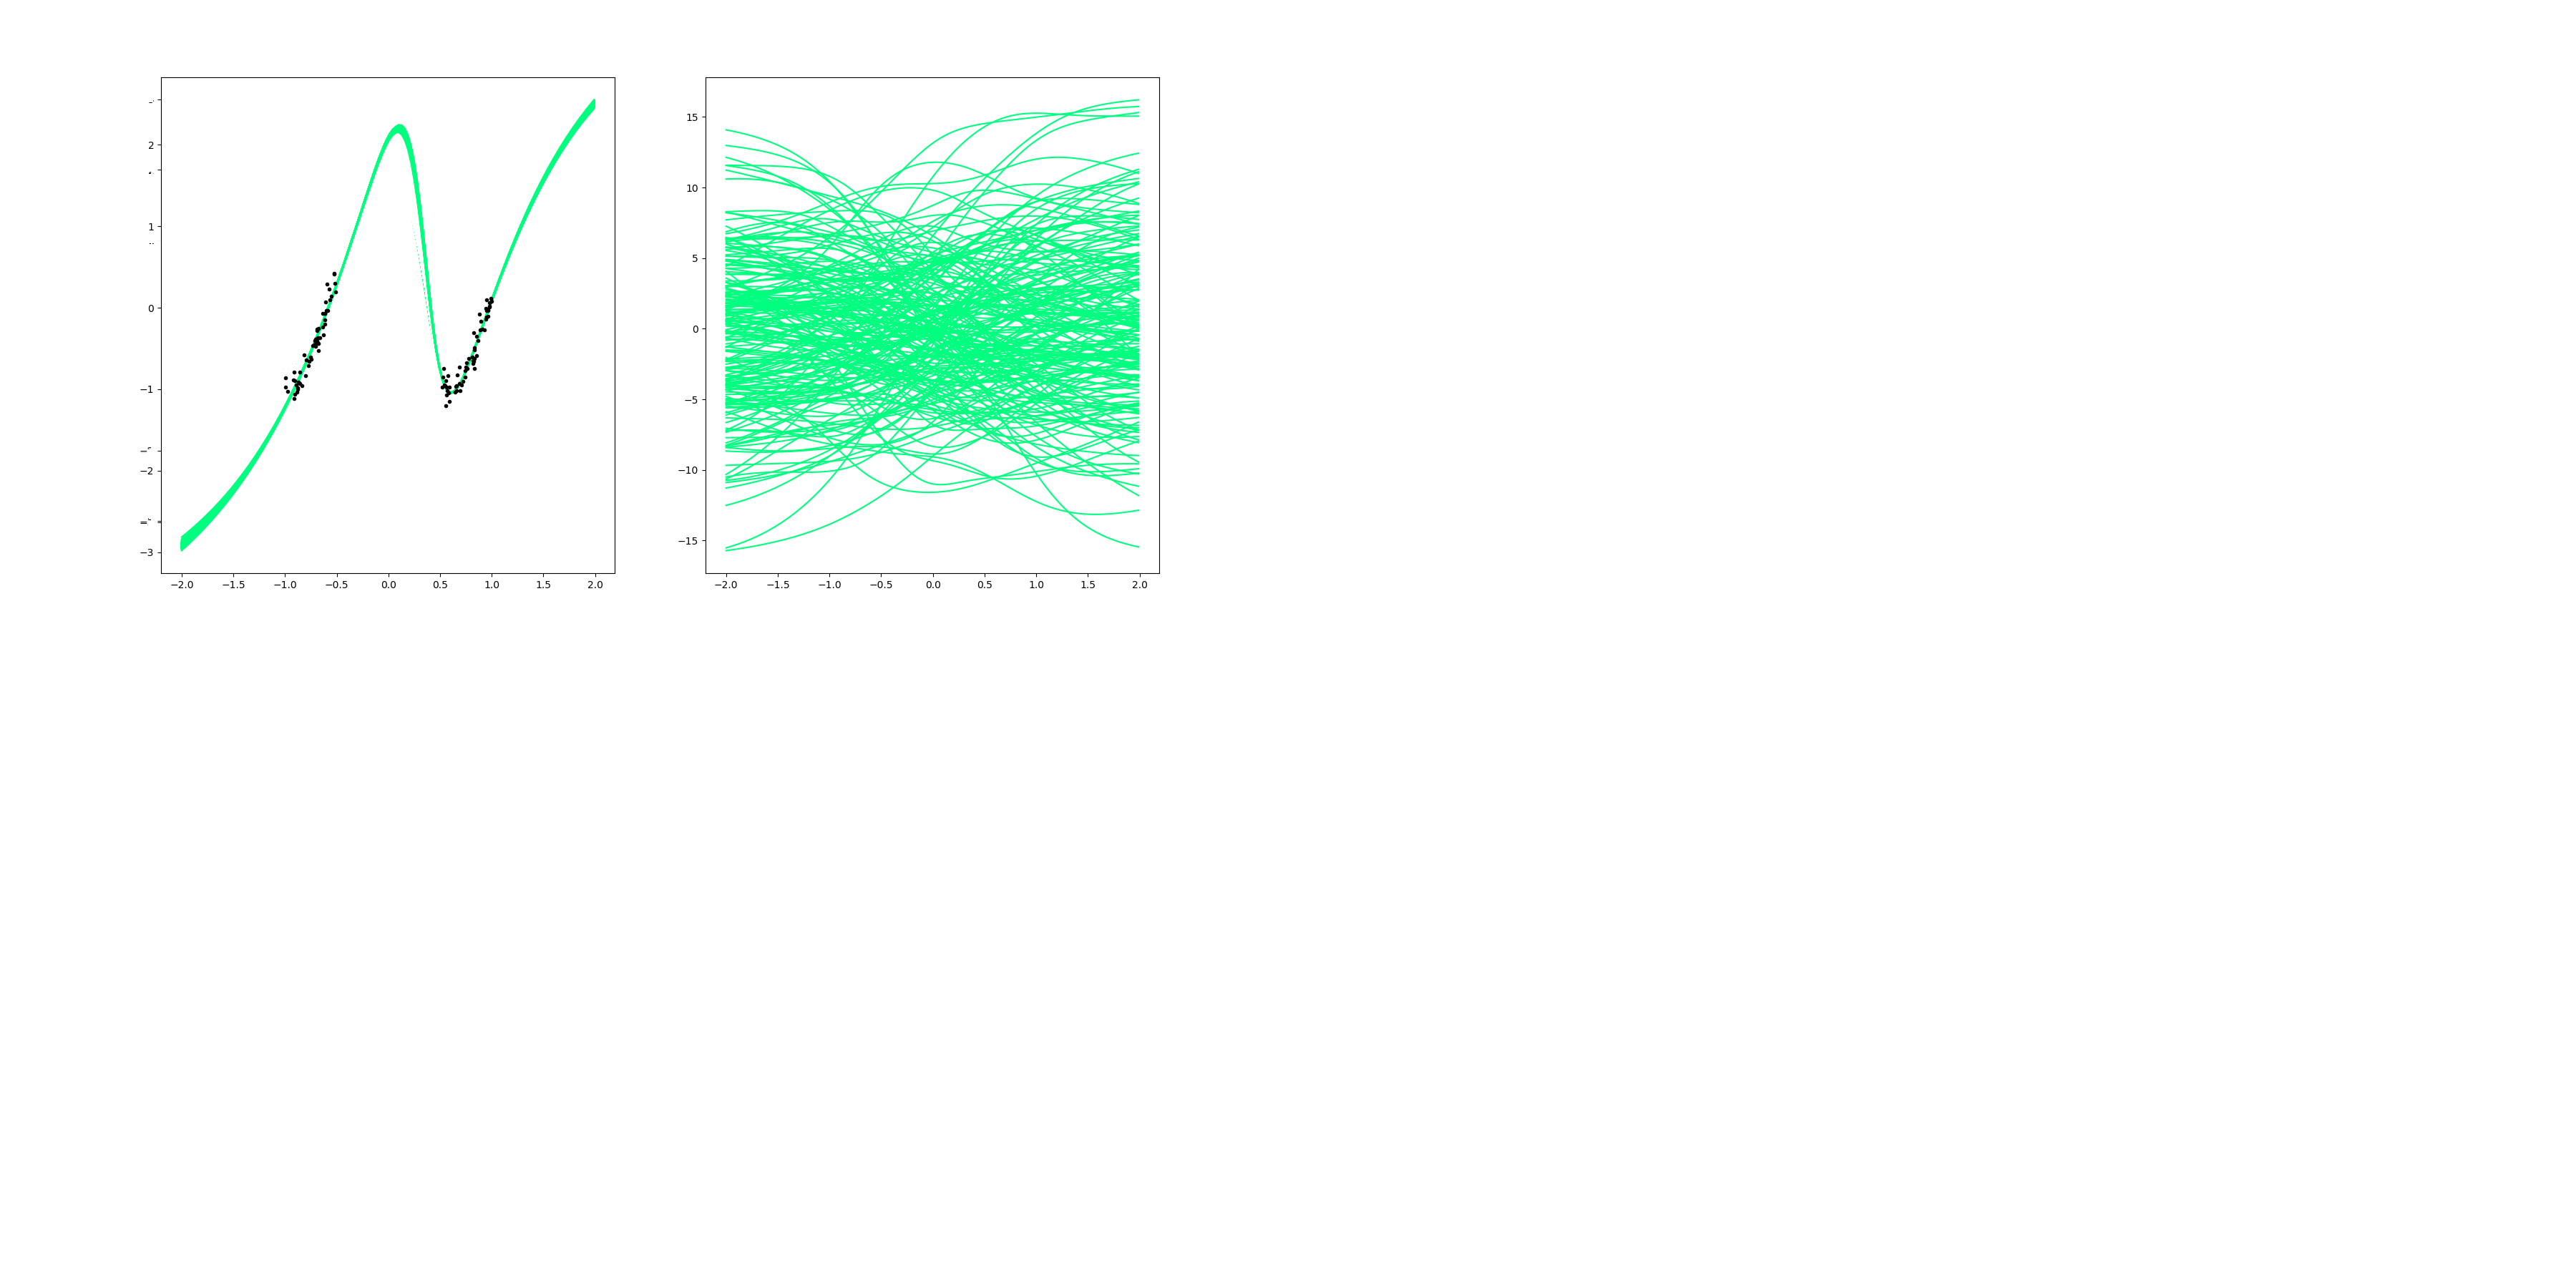

 23%|██▎       | 22690/100000 [09:49<22:25, 57.48it/s, D=-109, G=-99.9, W=-9.03]   

In [ ]:
# ----------
#  Training
# ----------

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation



n_epochs=100000

n_fake_samples=500

n_critic=5

lambda_NP=10.


liveplot = LivePlotNotebook(generator,discriminator,n=200)    


with trange(n_epochs) as tr:
    for epoch in tr:

        # Configure input
        real_X, real_y =X_train, y_train

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()
        
        # Sample noise as generator input
        z = Tensor(np.random.normal(0, 1, (n_fake_samples, lat_dim)))
        # Generate a batch of fake paramters
        fake_params = generator(z)
        prior_params=Tensor(np.random.normal(0, 1, (n_fake_samples, param_count)))

        fake_func=projection(fake_params,k_MC)

        prior_func=projection(prior_params,k_MC)
        # Real images
        real_validity = discriminator(prior_func)
        # Fake images
        fake_validity = discriminator(fake_func)
        # Gradient penalty
       # norm_penalty  = compute_norm_penalty(discriminator, prior_func, fake_func)
        grad_penalty = compute_gradient_penalty(discriminator, prior_func, fake_func)
        # Adversarial loss
        d_loss = -torch.mean(real_validity)   + torch.mean(fake_validity)+lambda_NP*grad_penalty#+ 10.*norm_penalty 
        d_loss.backward()
        optimizer_D.step()
        
        optimizer_G.zero_grad()


        

        # Train the generator every n_critic steps
        if epoch % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Sample noise as generator input
            z = Tensor(np.random.normal(0, 1, (n_fake_samples, lat_dim)))
            # Generate a batch of fake paramters
            fake_params = generator(z)
            prior_params=Tensor(np.random.normal(0, 1, (n_fake_samples, param_count)))
            
            fake_func=projection(fake_params,k_MC)

            prior_func=projection(prior_params,k_MC)

            # Real images
            real_validity = discriminator(prior_func)
            # Fake images
            fake_validity = discriminator(fake_func)

            # Adversarial loss
            W =  - torch.mean(fake_validity)
            g_loss = W -loglikelihood(fake_params).mean() #+ sqloss(fake_params).mean()
            g_loss.backward()
            optimizer_G.step()

        tr.set_postfix(D=d_loss.item(), G=g_loss.item(), W=W.item())
        
        if epoch % 100 == 0:
            liveplot.update(generator,discriminator)
            #z = Tensor(np.random.normal(0, 1, (200, lat_dim)))
            #theta=generator(z)

            #fig=setup.makePlot(theta,device)
            #plt.pause(1.)
            #plt.close()
            #showd(discriminator,200)
        

plt.show()

    